In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tqdm import tqdm
from utils.image_processing import processSingleImage
from spikingjelly.activation_based import neuron, learning, encoding, functional

In [49]:
''' Parameters '''
n_in = 28 * 28
n_out = 5

decay_lif = 2.
epochs = 15
T = 255
lr = 1e-3
tau_pre = 245.
tau_post = 150.
ap = 1
am = 1
threshold = 1.
w_mean = 0.3
std = 0.15

In [50]:
def stdp_training(net, epochs, learner, optimizer, encoder, training_data):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pbar = tqdm(
        desc=f"VPR SNN Trainig on {device}",
        total=epochs,
        position=0
    )
    weights = []
    for _ in range(epochs):
        for img in training_data:
            if type(encoder) == encoding.LatencyEncoder:
                for _ in range(encoder.T):
                    net[1].weight.data = net[1].weight.data.clamp(0,1)
                    weights.append(net[1].weight.data[0].detach().clone().numpy())
                    encoded_img = encoder(img)
                    s_out = net(encoded_img)
                    optimizer.step()
                    learner.step(on_grad=True)
                encoder.reset() # Reset stateful encoder
            else: #PoissonEncoder
                encoded_img = encoder(img)
                s_out = net(encoded_img)
                optimizer.step()
                learner.step(on_grad=True)
        pbar.update(1)
    pbar.close()
    return weights

In [51]:
def get_training_data():
    training_data = []
    img = processSingleImage("/home/geoffroy/images-00000.png", 28, 28, 7)
    img = torch.from_numpy(img).float()
    img = img.unsqueeze(0)
    training_data.append(img)
    return training_data

In [52]:
def f_pre(x):
    return torch.clamp(x, 0, ap)
    #return torch.clamp(x, 0, 1)

def f_post(x):
    return torch.clamp(x, 0, am)
    #return torch.clamp(x, 0, 1)

net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_in, n_out, bias=False),
    neuron.LIFNode(tau=decay_lif, v_threshold=threshold)
)

print(net)

net[1].weight.data = nn.init.normal_(net[1].weight.data, mean=0.6, std=0.15)
encoder = encoding.LatencyEncoder(T)
stdp_learner = learning.STDPLearner(
    synapse=net[1],
    sn=net[2],
    tau_pre=tau_pre,
    tau_post=tau_post,
    f_pre=f_pre,
    f_post=f_post,
    step_mode='s'
)
stdp_optimizer = torch.optim.SGD(net[1].parameters(), lr=lr, momentum=0.)

training_data = get_training_data()

weights = stdp_training(net, epochs, stdp_learner, stdp_optimizer, encoder, training_data)

functional.reset_net(net)
stdp_learner.reset()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=5, bias=False)
  (2): LIFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch, tau=2.0
    (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
  )
)


VPR SNN Trainig on cpu: 100%|███████████████████| 15/15 [00:01<00:00, 11.73it/s]


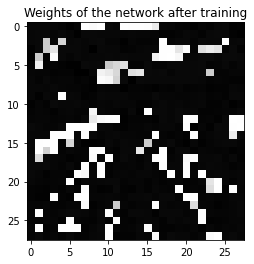

In [53]:
plt.imshow(net[1].weight[0].data.reshape(28,28), cmap="gray")
plt.title("Weights of the network after training")
plt.show()

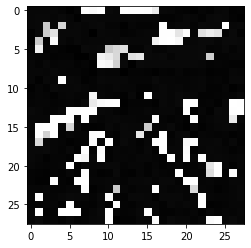

In [54]:
a = net[1].weight.data[0]
b = (a - min(a)) / (max(a) - min(a))
plt.imshow(b.reshape(28,28), cmap="gray")
plt.show()

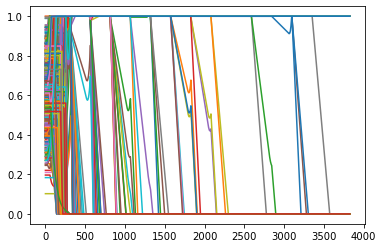

In [55]:
weights = np.array(weights)
plt.plot(weights)
plt.show()